Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.1
IPython 7.4.0

torch 1.1.0


# Dating Historical Color Images -- Using PyTorch Dataset Loading Utilities for Custom Datasets

This notebook provides an example for how to load an image dataset, stored as individual PNG/JPG files, using PyTorch's data loading utilities. For a more in-depth discussion, please see the official

- [Data Loading and Processing Tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
- [torch.utils.data](http://pytorch.org/docs/master/data.html) API documentation

In this example, we are using the cropped version of the **Dating Historical Color Images** dataset [1], which is available at http://graphics.cs.cmu.edu/projects/historicalColor/. 

To execute the following examples, you need to download the 2 ".mat" files 

- [train_32x32.mat](http://ufldl.stanford.edu/housenumbers/train_32x32.mat) (ca. 182 Mb, 73,257 images)
- [test_32x32.mat](http://ufldl.stanford.edu/housenumbers/test_32x32.mat) (ca. 65 Mb, 26,032 images)

## Dataset Info

The historical color image dataset is a rather small dataset depicting color images depicted from different decades. There are 5 classes in this dataset (1930, 1940, 1950, 1960, and 1970) referring to the decade a given picture was taken in. Each class consists of 256 images.

## References

- [1] Palermo, F., Hays, J., Efros, A.A.: Dating Historical Color Images. In: Fitzgibbon, A., Lazebnik, S., Sato, Y., Schmid, C. (eds.) ECCV 2012, Part VI. LNCS, vol. 7577, pp. 499-512. Springer, Heidelberg (2012)


## Imports

In [2]:
import pandas as pd
import numpy as np
import os

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
import imageio

## Downloading and Extracting the Dataset

The following bash commands (executed in this Jupyter notebook) will download and extract the dataset.

In [3]:
!curl http://graphics.cs.cmu.edu/projects/historicalColor/HistoricalColor-ECCV2012-DecadeDatabase.tar > HistoricalColor-ECCV2012-DecadeDatabase.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  211M  100  211M    0     0  10.0M      0  0:00:20  0:00:20 --:--:-- 9454k


In [4]:
!tar -xf  HistoricalColor-ECCV2012-DecadeDatabase.tar

## Investigating the Dataset

After extracting the dataset, we find that it is structured as follows. 
        
```        
HistoricalColor-ECCV2012
|_ data
       |_ img
              |_ decade_database
                    |_   1930s
                    |_   1940s
                    |_   1950s
                    |_   1960s
                    |_   1970s
```

Each folder `19??s` contains 256 images in `.jpg` format.

Note that the images in this database do not share the same resolution. Let's collect the individual image resolutions for further investigation.

In [5]:
from pathlib import Path

all_jpg_paths = [filename for filename
                 in Path('HistoricalColor-ECCV2012').glob('**/**/*.jpg')]
print(f'Number of jpgs: {len(all_jpg_paths)}')

Number of jpgs: 1325


Let's have a look at a few example files:

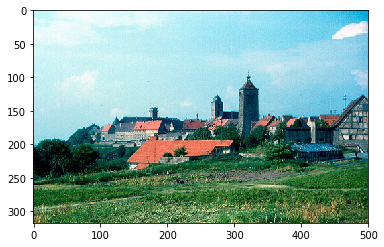

In [6]:
im = imageio.imread(all_jpg_paths[0])
plt.imshow(im);

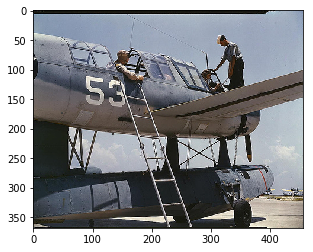

In [7]:
im = imageio.imread(all_jpg_paths[-1])
plt.imshow(im);

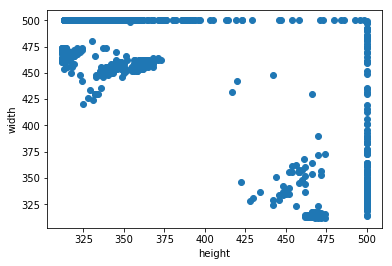

In [8]:
all_heights, all_widths = [], []

for path in all_jpg_paths:
    im = imageio.imread(path)
    all_heights.append(im.shape[0])
    all_widths.append(im.shape[1])
    
plt.scatter(all_heights, all_widths)
plt.xlabel('height')
plt.ylabel('width')
plt.show()

In [9]:
print(f'Min height: {min(all_heights)}')
print(f'Min width: {min(all_widths)}')

Min height: 312
Min width: 312


As it appears that the images not only have different resolutions but also different aspect ratios, it may not be a bad idea to do random crops during training of a deep learning model. I.e., 300x300 pixel random crops may not be a bad idea as it would also help with taking care of the aspect ratio issue. We may then use 312x312 pixel center crops for testing.

## Creating Label Files

PyTorch has a nice utility class called [`torchvision.datasets.ImageFolder`](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) that may be helpful for circumventing the need for creating seperate labels files for the class labels. The downside of that is though that it doesn't conveniently allow us to make a test portion for the dataset, and also, it requires using the same dataloader. Hence, since label files in CSV are also useful in terms of sharing the partitioning, let us create label CSV files before we proceed with creating `DataLoader`s.

In [10]:
os.path.basename(os.path.dirname(all_jpg_paths[0]))

'1960s'

In [11]:
class_label_mapping = {'1930s': 0,
                       '1940s': 1,
                       '1950s': 2,
                       '1960s': 3,
                       '1970s': 4}

df = pd.DataFrame(all_jpg_paths, columns=['paths'])
df['year'] = df['paths'].apply(lambda x: os.path.basename(os.path.dirname(x)))
df['labels'] = df['year'].map(class_label_mapping)
df.head()

,paths,year,labels
0,HistoricalColor-ECCV2012/data/imgs/decade_data...,1960s,3
1,HistoricalColor-ECCV2012/data/imgs/decade_data...,1960s,3
2,HistoricalColor-ECCV2012/data/imgs/decade_data...,1960s,3
3,HistoricalColor-ECCV2012/data/imgs/decade_data...,1960s,3
4,HistoricalColor-ECCV2012/data/imgs/decade_data...,1960s,3


Next, we are doing a stratified split that divides the dataset into 80% training data and 20% test data while preserving the class propotions.

In [12]:
from sklearn.model_selection import train_test_split


df_train, df_test = \
        train_test_split(df, 
                         stratify=df['labels'].values, 
                         random_state=123, 
                         test_size=0.2)

Finally, we are going to save the dataset partitioning to disk:

In [13]:
df_train.to_csv('HistoricalColor-train.csv', index=False)
df_test.to_csv('HistoricalColor-test.csv', index=False)

## Implementing a Custom Dataset Class

Now, we implement a custom `Dataset` for reading the images. The `__getitem__` method will

1. read a single image from disk based on an `index` (more on batching later)
2. perform a custom image transformation (if a `transform` argument is provided in the `__init__` construtor)
3. return a single image and it's corresponding label

In [14]:
class HistoricalColorDataset(Dataset):
    """Custom Dataset for the HistoricalColor images"""
    
    def __init__(self, csv_path, root_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col='paths')
        self.root_dir = root_dir
        self.csv_path = csv_path
        self.img_paths = df.index.values
        
        self.y = df['labels'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.root_dir,
                                      self.img_paths[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

Now that we have created our custom Dataset class, let us add some custom transformations via the `transforms` utilities from `torchvision`, we

1. normalize the images (here: dividing by 255)
2. crop the images
3. convert the image arrays into PyTorch tensors


Finally, we initialize a `DataLoader` that allows us to read from the dataset.

In [15]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform_train = transforms.Compose([#transforms.Grayscale(),                                       
                                             #transforms.Lambda(lambda x: x/255.),
                                             transforms.RandomCrop((312, 312)),
                                             transforms.ToTensor()])

custom_transform_test = transforms.Compose([#transforms.Grayscale(),                                       
                                            #transforms.Lambda(lambda x: x/255.),
                                            transforms.CenterCrop((312, 312)),
                                            transforms.ToTensor()])

train_dataset = HistoricalColorDataset(csv_path='HistoricalColor-train.csv',
                                       root_dir='.',
                                       transform=custom_transform_train)

test_dataset = HistoricalColorDataset(csv_path='HistoricalColor-test.csv',
                                      root_dir='.',
                                      transform=custom_transform_test)

BATCH_SIZE=128


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

That's it, now we can iterate over an epoch using the train_loader as an iterator and use the features and labels from the training dataset for model training:

## Iterating Through the Custom Dataset

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


Just to make sure that the batches are being loaded correctly, let's print out the dimensions of the last batch:

In [17]:
x.shape

torch.Size([128, 3, 312, 312])

As we can see, each batch consists of 128 images, just as specified. However, one thing to keep in mind though is that
PyTorch uses a different image layout (which is more efficient when working with CUDA); here, the image axes are "num_images x channels x height x width" (NCHW) instead of "num_images height x width x channels" (NHWC):

To visually check that the images that coming of the data loader are intact, let's swap the axes to NHWC and convert an image from a Torch Tensor to a NumPy array so that we can visualize the image via `imshow`:

In [18]:
one_image = x[0].permute(1, 2, 0)
one_image.shape

torch.Size([312, 312, 3])

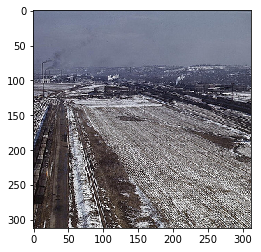

In [19]:
# note that imshow also works fine with scaled
# images in [0, 1] range.
plt.imshow(one_image.to(torch.device('cpu')));

In [20]:
%watermark -iv

numpy       1.16.2
PIL.Image   5.4.1
imageio     2.5.0
scipy       1.2.1
torchvision 0.2.3a0+ccbb322
matplotlib  3.0.3
torch       1.1.0
pandas      0.24.2

